# Dataset Download

In [1]:
import os
import urllib.request

In [2]:
DATA_FOLDER = os.path.join(os.getcwd(), 'datasets/mnist-data')
DATASET_BASE_URL = 'https://azureopendatastorage.blob.core.windows.net/mnist/'
os.makedirs(DATA_FOLDER, exist_ok=True)

In [3]:
urllib.request.urlretrieve(
    os.path.join(DATASET_BASE_URL, 'train-images-idx3-ubyte.gz'),
    filename=os.path.join(DATA_FOLDER, 'train-images.gz'))
urllib.request.urlretrieve(
    os.path.join(DATASET_BASE_URL, 'train-labels-idx1-ubyte.gz'),
    filename=os.path.join(DATA_FOLDER, 'train-labels.gz'))
urllib.request.urlretrieve(
    os.path.join(DATASET_BASE_URL, 't10k-images-idx3-ubyte.gz'),
    filename=os.path.join(DATA_FOLDER, 'test-images.gz'))
urllib.request.urlretrieve(
    os.path.join(DATASET_BASE_URL, 't10k-labels-idx1-ubyte.gz'),
    filename=os.path.join(DATA_FOLDER, 'test-labels.gz'))

('/mnt/batch/tasks/shared/LS_root/mounts/clusters/demo-ws-computeinst/code/datasets/mnist-data/test-labels.gz',
 <http.client.HTTPMessage at 0x7fda77435be0>)

# Dataset Load and Exploration

In [4]:
import gzip
import struct
import numpy as np

In [5]:
def load_dataset(dataset_path):
    def unpack_mnist_data(filename: str, label=False):
        with gzip.open(filename) as gz:
            struct.unpack('I', gz.read(4))
            n_items = struct.unpack('>I', gz.read(4))
            if not label:
                n_rows = struct.unpack('>I', gz.read(4))[0]
                n_cols = struct.unpack('>I', gz.read(4))[0]
                res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
                res = res.reshape(n_items[0], n_rows * n_cols) / 255.0
            else:
                res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
                res = res.reshape(-1)
        return res
    
    X_train = unpack_mnist_data(os.path.join(dataset_path, 'train-images.gz'), False)
    y_train = unpack_mnist_data(os.path.join(dataset_path, 'train-labels.gz'), True)
    X_test = unpack_mnist_data(os.path.join(dataset_path, 'test-images.gz'), False)
    y_test = unpack_mnist_data(os.path.join(dataset_path, 'test-labels.gz'), True)

    return X_train.reshape(-1,28,28,1), y_train, X_test.reshape(-1,28,28,1), y_test

In [6]:
X_train, y_train, X_test, y_test = load_dataset(DATA_FOLDER)

In [7]:
print(X_train.shape)

(60000, 28, 28, 1)


In [8]:
import matplotlib.pyplot as plt

In [9]:
def show_images(images, labels):
    images_cnt = len(images)
    assert images_cnt <= 10, f"Number of images cannot exceed 10. The provided list has {images_cnt} elements."
    assert images_cnt == len(labels), f"Number of images ({images_cnt}) should be equal to number of labels ({len(labels)})"
    f, axarr = plt.subplots(nrows=1, ncols=images_cnt, figsize=(16,16))
    for idx in range(images_cnt):
        img = images[idx]
        lab = labels[idx]
        axarr[idx].imshow(img, cmap='gray_r')
        axarr[idx].title.set_text(lab)
        axarr[idx].axis('off')

    plt.show()    

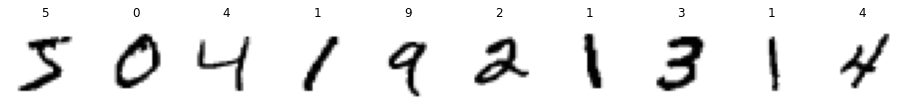

In [10]:
show_images(X_train[:10], y_train[:10])

# TensorFlow Model

In [11]:
import tensorflow as tf

In [12]:
def create_tf_model():
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(filters=10, kernel_size=5, input_shape=(28,28,1), activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(filters=20, kernel_size=5, activation='relu'),
            tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(320, activation='relu'),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10, activation='relu')
        ]
    )
    
    return model

In [13]:
model = create_tf_model()

In [14]:
model.build()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 20)          5020      
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 20)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 320)               1

In [16]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [17]:
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

# Prepare Azure ML Experiment

In [18]:
from azureml.core import Workspace, Experiment
import mlflow, mlflow.tensorflow

In [19]:
SUBSCRIPTION="<your-subscription-id>"
GROUP="azureml-rg"
WORKSPACE="demo-ws"

In [20]:
ws = Workspace(
    subscription_id=SUBSCRIPTION,
    resource_group=GROUP,
    workspace_name=WORKSPACE,
)
experiment = Experiment(ws, "aml-demo-tf-notebook-training")

In [21]:
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.start_run(experiment_id=experiment.id)
mlflow.tensorflow.autolog()

# Start Training

In [22]:
tf.random.set_seed(101)

In [23]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2171 - accuracy: 0.9342
Epoch 2/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0705 - accuracy: 0.9794
Epoch 3/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0536 - accuracy: 0.9851
Epoch 4/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0399 - accuracy: 0.9884
Epoch 5/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0360 - accuracy: 0.9897
INFO:tensorflow:Assets written to: /tmp/tmpdxskcjgd/model/data/model/assets


In [24]:
mlflow.end_run()

# Model Evaluation and Registration in AzureML

In [25]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0451 - accuracy: 0.9864


[0.04506488889455795, 0.9864000082015991]

In [26]:
model.save('mnist-tf-model.h5')

In [27]:
from azureml.core.model import Model

In [28]:
registered_model = Model.register(
    workspace=ws,
    model_name='mnist-tf-model',
    model_path='mnist-tf-model.h5',
    model_framework=Model.Framework.TENSORFLOW,
    model_framework_version=tf.__version__)

Registering model mnist-tf-model


In [29]:
registered_model

Model(workspace=Workspace.create(name='demo-ws', subscription_id='aa0c9c06-de93-4fbf-a84b-642425935e77', resource_group='azureml-rg'), name=mnist-tf-model, id=mnist-tf-model:5, version=5, tags={}, properties={})

# Load Registered Model

In [30]:
aml_model = Model(workspace=ws, name='mnist-tf-model', version=registered_model.version)

In [31]:
downloaded_model_filename = aml_model.download(exist_ok=True)
print(downloaded_model_filename)

mnist-tf-model.h5


In [32]:
downloaded_model = tf.keras.models.load_model(downloaded_model_filename)

In [33]:
downloaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 20)          5020      
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 20)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 320)               1

# Evaluate Loaded Model

In [34]:
preds = downloaded_model.predict(X_test).argmax(axis=1)

In [35]:
print(preds)
print(y_test)

[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


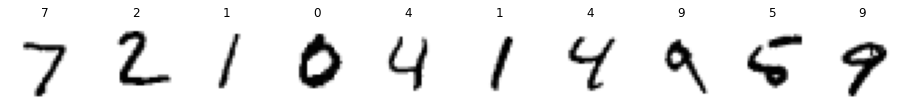

In [36]:
show_images(X_test[:10], preds[:10])

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
accuracy_score(y_test, preds)

0.9864

In [39]:
downloaded_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0451 - accuracy: 0.9864


[0.04506488889455795, 0.9864000082015991]